# 95-869: Big Data and Large-Scale Computing Homework 5


## **Yelp Dataset Assignment**

This project delves into exploratory analysis and building predictive models using the [Yelp academic dataset](https://www.yelp.com/dataset_challenge/). It is an opportunity for you to explore machine learning tasks in the context of a real-world data set using big data analysis tools. In order to use the dataset and finish this project, you must agree to the dataset's terms of use provided [here](https://www.yelp.com/html/pdf/Dataset_Challenge_Academic_Dataset_Agreement.pdf).

We have chosen a subset of the Yelp academic dataset for you to work with. This subsampled data is loaded into RDDs in part (0). The complete dataset is available from Yelp's website [here](https://www.yelp.com/dataset_challenge/dataset).

#### ** This assignment will cover: **
*  *Part 1 (30 Points):* Exploratory Data Analysis [Link](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) [Link](https://spark.apache.org/docs/2.2.0/api/python/pyspark.mllib.html#module-pyspark.mllib.stat)
*  *Part 2 (15 Points):* Prediction using tree ensemble methods [Link](https://spark.apache.org/docs/2.2.0/mllib-ensembles.html)
*  *Part 3 (20 Points):* Collaborative filtering for recommendation [Link](https://spark.apache.org/docs/2.2.0/mllib-collaborative-filtering.html)
*  *Part 4 (15 Points):* Topic modeling for text reviews [Link](https://spark.apache.org/docs/2.2.0/mllib-clustering.html#latent-dirichlet-allocation-lda)
*  *Part 5 (10 Points):* Word2Vec for text reviews [Link](https://spark.apache.org/docs/2.2.0/api/python/pyspark.mllib.html#pyspark.mllib.feature.Word2Vec)
*  *Part 6 (10 Points):* Frequent pattern mining using FP-Growth algorithm [Link](https://spark.apache.org/docs/2.2.0/mllib-frequent-pattern-mining.html)
*  *Part 7 (Bonus: 20 Points):* Any additional and insightful exploratory data analysis or machine learning tasks you want to do.

#### Note that, for reference, you can look up the details of the relevant Spark methods in [Spark's Python API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) and the relevant NumPy methods in the [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html)

### ** Code of Conduct **

** Please follow the following guidelines with respect to collaboration: **

* By using the dataset, you agree to Yelp's terms of use available [here](https://www.yelp.com/html/pdf/Dataset_Challenge_Academic_Dataset_Agreement.pdf).
* You are free to use the Web, APIs, ML toolkits, etc. in this project to your best benefit. Please cite any online or offline sources (even casual sources like StackOverflow) if you use them in the project.
* The assignment is to be done individually. No collaboration is allowed between students. No discussion is allowed about the project with anyone else except the class instructors.

## Submission Instructions:


You will submit both an html and a Jupyter Notebook on Canvas. You will submit a PDF on Gradescope and assign the pages to their corresponding questions. No printout submission is expected. The submission issues below will result in points deduction:

1. If the student doesn't make the submission on both Canvas and Gradescope: -5% 
2. If the student submits an empty jupyter notebook/version obviously different from the submitted PDF: -5%
3. If the student does't assign pages to questions on Gradescope: -3%

Rename the notebook from "hw5_yelp_student.ipynb" to "studentid_hw5_yelp_student.ipynb" where "studentid" is your Andrew ID. Complete the assignment, execute all cells in the completed notebook, and make sure all results show up. Export the contents of the notebook by choosing "File > Download as > HTML" and saving the resulting file as "studentid_hw5_yelp_student.html" Convert the exported HTML file to PDF by using a feature such as the "Save as PDF" feature on Mac. Another way to get the PDF file is to do ctrl(or command) + P and save as a PDF. Submit the PDF solution to gradescope. Submit the IPython and exported html solution files on Canvas.

# ** Part 0: Load the datasets required for the project **

We will load four datasets for this project. In addition to the four datasets, we will also load two lists which contain names by gender. These lists are helpful in assigning a gender to a Yelp user by their name, since gender is not available in the Yelp dataset.

Let's first start by creating the SparkContext.

In [1]:
import sys
sys.path.append("/opt/packages/spark/latest/python/lib/py4j-0.10.9-src.zip")
sys.path.append("/opt/packages/spark/latest/python/")
sys.path.append("/opt/packages/spark/latest/python/pyspark")
from pyspark import SparkConf, SparkContext

conf = SparkConf().setAppName("my_app_name").setMaster("local[*]").set("spark.driver.memory", "25g")
sc = SparkContext(conf=conf)
sc

23/04/30 12:43:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


<SparkContext master=local[*] appName=my_app_name>

In [2]:
import json
import os
import sys
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# helper function to load a JSON dataset from a publicly accessible url
def get_rdd_from_path(path):
    file_reader = open(path, 'r')
    str_contents = file_reader.readlines()
    json_contents = [json.loads(x.strip()) for x in str_contents]
    rdd = sc.parallelize(json_contents,  numSlices=1000)
    return rdd

The first dataset we are going to load is information about Yelp businesses. The information of each business will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

* "business_id":"encrypted business id"
* "name":"business name"
* "neighborhood":"hood name"
* "address":"full address"
* "city":"city"
* "state":"state -- if applicable --"
* "postal code":"postal code"
* "latitude":latitude
* "longitude":longitude
* "stars":star rating, rounded to half-stars
* "review_count":number of reviews
* "is_open":0/1 (closed/open)
* "attributes":["an array of strings: each array element is an attribute"]
* "categories":["an array of strings of business categories"]
* "hours":["an array of strings of business hours"]
* "type": "business"

In [3]:
# load the data about Yelp businesses in an RDD
# each RDD element is a Python dictionary parsed from JSON using json.loads()
businesses_rdd = get_rdd_from_path('/ocean/projects/cis220071p/shared/data/yelp_academic_dataset_business.json')
print (businesses_rdd.count())
print (businesses_rdd.take(2))

61184
[{'business_id': 'vcNAWiLM4dR7D2nwwJ7nCA', 'full_address': '4840 E Indian School Rd\nSte 101\nPhoenix, AZ 85018', 'hours': {'Tuesday': {'close': '17:00', 'open': '08:00'}, 'Friday': {'close': '17:00', 'open': '08:00'}, 'Monday': {'close': '17:00', 'open': '08:00'}, 'Wednesday': {'close': '17:00', 'open': '08:00'}, 'Thursday': {'close': '17:00', 'open': '08:00'}}, 'open': True, 'categories': ['Doctors', 'Health & Medical'], 'city': 'Phoenix', 'review_count': 9, 'name': 'Eric Goldberg, MD', 'neighborhoods': [], 'longitude': -111.983758, 'state': 'AZ', 'stars': 3.5, 'latitude': 33.499313, 'attributes': {'By Appointment Only': True}, 'type': 'business'}, {'business_id': 'UsFtqoBl7naz8AVUBZMjQQ', 'full_address': '202 McClure St\nDravosburg, PA 15034', 'hours': {}, 'open': True, 'categories': ['Nightlife'], 'city': 'Dravosburg', 'review_count': 4, 'name': "Clancy's Pub", 'neighborhoods': [], 'longitude': -79.88693, 'state': 'PA', 'stars': 3.5, 'latitude': 40.350519, 'attributes': {'Hap

The second dataset we are going to load is information about Yelp users. Each user's information will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

*  "user_id":"encrypted user id"
*  "name":"first name"
*  "review_count":number of reviews
*  "yelping_since": date formatted like "2009-12-19"
*  "friends":["an array of encrypted ids of friends"]
*  "useful":"number of useful votes sent by the user"
*  "funny":"number of funny votes sent by the user"
*  "cool":"number of cool votes sent by the user"
*  "fans":"number of fans the user has"
*  "elite":["an array of years the user was elite"]
*  "average_stars":floating point average like 4.31
*  "compliment_hot":number of hot compliments received by the user
*  "compliment_more":number of more compliments received by the user
*  "compliment_profile": number of profile compliments received by the user
*  "compliment_cute": number of cute compliments received by the user
*  "compliment_list": number of list compliments received by the user
*  "compliment_note": number of note compliments received by the user
*  "compliment_plain": number of plain compliments received by the user
*  "compliment_cool": number of cool compliments received by the user
*  "compliment_funny": number of funny compliments received by the user
*  "compliment_writer": number of writer compliments received by the user
*  "compliment_photos": number of photo compliments received by the user
*  "type":"user"

In [4]:
# load the data about Yelp users in an RDD
# each RDD element is a Python dictionary parsed from JSON using json.loads()
users_rdd = get_rdd_from_path('/ocean/projects/cis220071p/shared/data/yelp_academic_dataset_user.json')
print (users_rdd.count())
print (users_rdd.take(2))

366715
[{'yelping_since': '2004-10', 'votes': {'funny': 166, 'useful': 278, 'cool': 245}, 'review_count': 108, 'name': 'Russel', 'user_id': '18kPq7GPye-YQ3LyKyAZPw', 'friends': ['rpOyqD_893cqmDAtJLbdog', '4U9kSBLuBDU391x6bxU-YA', 'fHtTaujcyKvXglE33Z5yIw', '8J4IIYcqBlFch8T90N923A', 'wy6l_zUo7SN0qrvNRWgySw', 'HDQixQ-WZEV0LVPJlIGQeQ', 'T4kuUr_iJiywOPdyM7gTHQ', 'z_5D4XEIlGAPjG3Os9ix5A', 'i63u3SdbrLsP4FxiSKP0Zw', 'pnrGw4ciBXJ6U5QB2m0F5g', 'ytjCBxosVSqCOQ62c4KAxg', 'r5uiIxwJ-I-oHBkNY2Ha3Q', 'niWoSKswEbooJC_M7HMbGw', 'kwoxiKMyoYjB1wTCYAjYRg', '9A8OuP6XwLwnNb9ov3_Ncw', '27MmRg8LfbZXNEHkEnKSdA', 'Bn4sJUTtKFZQt0FKHF2Adw', 'uguXfIEpI65jSCH5MgUDgA', '6VZNGc2h2Bn-uyuEXgOt5g', 'AZ8CTtwr-4sGM2kZqF6qig', 'S742m-AuQicMSLDdErrLZQ', 'uGmQ6ab4iVpWn5m61VFhkQ', 'GJYJX4SujVj3BR8v2F9PDQ', '3shjifK-vZkIHciyy_KbYA', '4lc_H2Cf7CO0tCgyA3aSVQ', 'Tunkp_F1R_uFBJQTsDxD4g', 'B9pKfr27czBbCoAIircZdQ', 'pePGMO6EbDpbaZ7D2m6HIg', 'XRM8W6HUoXbrYKR3BCj9Rg', '8DqIWXsKXOipfduYEfFpNw', 'dvRVX54Z9f7Om51NsTRX1w', 'CM0saLQmk4oAB17

The third dataset we are going to load is information about business checkins reported by users on Yelp. Each checkin's information will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

*  "checkin_info":["an array of check ins with the format day-hour:number of check ins from hour to hour+1"]
*  "business_id":"encrypted business id"
*  "type":"checkin"

In [5]:
# load the data about business checkins reported by users on Yelp in an RDD
# each RDD element is a Python dictionary parsed from JSON using json.loads()
checkins_rdd = get_rdd_from_path('/ocean/projects/cis220071p/shared/data/yelp_academic_dataset_checkin.json')
print (checkins_rdd.count())
print (checkins_rdd.take(2))

45166
[{'checkin_info': {'9-5': 1, '7-5': 1, '13-3': 1, '17-6': 1, '13-0': 1, '17-3': 1, '10-0': 1, '18-4': 1, '14-6': 1}, 'type': 'checkin', 'business_id': 'cE27W9VPgO88Qxe4ol6y_g'}, {'checkin_info': {'22-5': 1, '9-5': 1, '15-1': 1, '15-4': 1, '16-2': 1, '21-4': 1, '13-1': 1, '14-4': 1, '12-5': 1, '12-1': 1}, 'type': 'checkin', 'business_id': 'mVHrayjG3uZ_RLHkLj-AMg'}]


The fourth dataset we are going to load is information about business reviews written by users on Yelp. Each review's data will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

*  "review_id":"encrypted review id"
*  "user_id":"encrypted user id"
*  "business_id":"encrypted business id"
*  "stars":star rating rounded to half-stars
*  "date":"date formatted like 2009-12-19"
*  "text":"review text"
*  "useful":number of useful votes received
*  "funny":number of funny votes received
*  "cool": number of cool review votes received
*  "type": "review"

In [6]:
# load the data about business reviews written by users on Yelp in an RDD, limited to businesses in Pittsburgh due to DataBricks computational limits
# each RDD element is a Python dictionary parsed from JSON using json.loads()
reviews_rdd = get_rdd_from_path('/ocean/projects/cis220071p/shared/data/yelp_academic_dataset_review_pittsburgh.json')
print (reviews_rdd.count())
print (reviews_rdd.take(2))

62608
[{'votes': {'funny': 3, 'useful': 7, 'cool': 7}, 'user_id': 'JbAeIYc89Sk8SWmrBCJs9g', 'review_id': 'fBQ69-NU9ZyTjjS7Tb5tww', 'stars': 5, 'date': '2013-06-10', 'text': "THANK YOU ROB! i truly appreciated all the help i received from this agent today who was able to removed the extra charges on my bill that the Pasadena Verizon Store on Lake was charging me on my bill for upgrading my phone.   When i went in i was having problems with my Blacberry and had to switch to the Iphone last week. Rob from the Pennsylvania store who i was connected today was able to look at my bill and all the notes and correct the problem immediately. Great Customer Service! He even set up a FOLLOW UP Phone Call with me On July 5th to make sure the credit goes through on my bill...I can't thank him enough!!!!", 'type': 'review', 'business_id': 'HZdLhv6COCleJMo7nPl-RA'}, {'votes': {'funny': 1, 'useful': 1, 'cool': 1}, 'user_id': 'l_szjd-ken3ma6oHDkTYXg', 'review_id': 'CFiLh7WvH7dM3qVZvNiacQ', 'stars': 2, '

Finally, we will load two lists. The first list consists of male names, and the second list consists of female names, to map Yelp user names to gender.

In [7]:
# helper function to load a list of names from a publicly accessible url
def get_names_from_path(path):
    file_reader = open(path, 'r')
    str_contents = file_reader.readlines()
    str_contents = [x.strip() for x in str_contents]
    result = str_contents[6:]
    return result

male_names = get_names_from_path('/ocean/projects/cis220071p/shared/data/male.txt')
print('First five male names: ', male_names[:5])
print('Number of male names: ', len(male_names))

female_names = get_names_from_path('/ocean/projects/cis220071p/shared/data/female.txt')
print('First five female names: ', female_names[:5])
print('Number of female names: ', len(female_names))

First five male names:  ['Aamir', 'Aaron', 'Abbey', 'Abbie', 'Abbot']
Number of male names:  2943
First five female names:  ['Abagael', 'Abagail', 'Abbe', 'Abbey', 'Abbi']
Number of female names:  5001


# ** Part 1: Exploratory Data Analysis **

Performing some exploratory analysis is a great step toward understanding the data before building any statistical machine learning models on it.

Please replace `<FILL IN>` with your solution. This is the general form that exercises will take. Exercises will include an explanation of what is expected, followed by code cells where one cell will have one or more `<FILL IN>` sections.  The cell that needs to be modified will have `# TODO: Replace <FILL IN> with appropriate code` on its first line.

In [8]:
print ('Number of businesses: ', businesses_rdd.count())
print ('Number of users: ', users_rdd.count())
print ('Number of checkins: ', checkins_rdd.count())
print ('Number of reviews: ', reviews_rdd.count())

Number of businesses:  61184
Number of users:  366715
Number of checkins:  45166
Number of reviews:  62608


** Question1: ** Print the top 5 business categories by frequency and the number of times they appear in the businesses data.

In [9]:
# TODO: Replace <FILL IN>

# Extract the categories from the business RDD
categories_rdd = businesses_rdd.flatMap(lambda x:x['categories'])

# Count the frequency of each category 
category_count_rdd = categories_rdd.map(lambda x:(x,1)).reduceByKey(lambda x,y:x+y)

# Sort the categories by frequency in descending order
sorted_categories_rdd = category_count_rdd.sortBy(lambda x:x[1], ascending=False)

# Take the top 5 caetgories
top_categories_rdd = sorted_categories_rdd.take(5)

# Print the category name and its frequency
for category, count in top_categories_rdd:
    print(f"{category}: {count}")


Restaurants: 21892
Shopping: 8919
Food: 7862
Beauty & Spas: 4738
Nightlife: 4340


** Question2: ** Print the top 5 cities by frequency and the number of times they appear in the businesses data.

In [10]:
# TODO: Replace <FILL IN>

# Extract the city from the businesses RDD
cities_rdd = businesses_rdd.map(lambda x:x['city'])

# Count the frequency of each city
city_count_rdd = cities_rdd.map(lambda x:(x,1)).reduceByKey(lambda x,y:x+y)

# sort the cities by frequency in descending order
sorted_cities_rdd = city_count_rdd.sortBy(lambda x:x[1], ascending=False)

# Take the top 5 cities
top_cities_rdd = sorted_cities_rdd.take(5)

# Print the city name and its frequency
for city, count in top_cities_rdd:
    print(f"{city}: {count}")

Las Vegas: 13601
Phoenix: 8410
Charlotte: 4224
Scottsdale: 4039
Edinburgh: 3031


** Question3: ** Plot the histogram of stars received by businesses.

Text(0, 0.5, 'Number of Businesses')

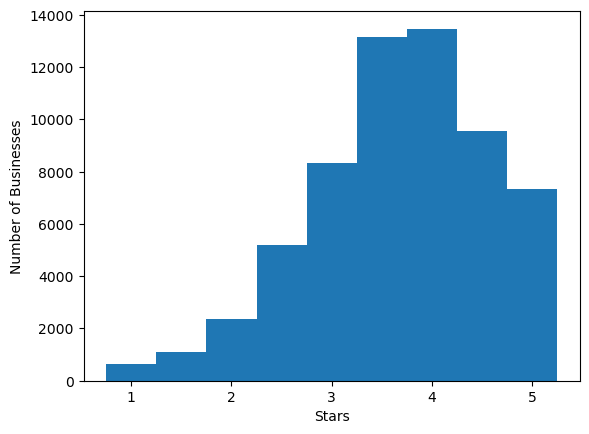

In [11]:
# TODO: Replace <FILL IN>

businesses_stars_counts = businesses_rdd.map(lambda x:x['stars']).collect()
plt.hist(businesses_stars_counts, bins=[x/2-0.25 for x in range(2, 12)]) # x/2-0.25 calculates the left edge of the bin
plt.xlabel('Stars')
plt.ylabel('Number of Businesses')

** Question4: ** Plot the histogram of number of reviews received by businesses.

Text(0, 0.5, 'Number of Businesses')

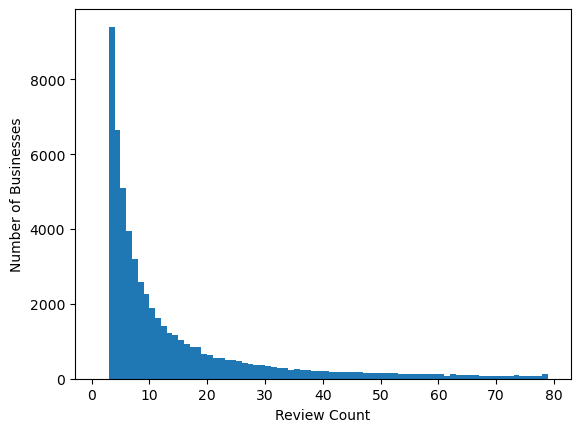

In [12]:
# TODO: Replace <FILL IN>

businesses_review_counts = businesses_rdd.map(lambda x:x['review_count']).collect()

plt.hist(businesses_review_counts, bins=range(1,80))
plt.xlabel('Review Count')
plt.ylabel('Number of Businesses')

** Question5: ** Plot the above histogram but now on a log-log scale using `bins=range(1,1000)`. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** Yes. When plotting the histogram of a dataset that follows a power law relationship on a log-log scale, the resulting plot will show a straight line. This is because the equation for a power law relationship, f(x) = ax^-k, can be rewritten as log(f(x)) = -k * log(ax), which is a linear equation with a slope of -k and an intercept of log(a). Therefore, plotting log(f(x)) against log(x) will show a linear relationship with a slope of -k, indicating that the original dataset follows a power law distribution. This property makes log-log plots useful for identifying power law relationships in datasets.

Text(0, 0.5, 'Number of Businesses')

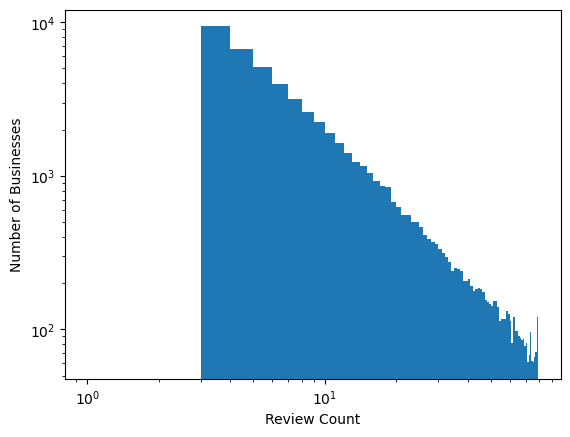

In [13]:
# TODO: Replace <FILL IN>

plt.hist(businesses_review_counts, bins=range(1,80))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Review Count')
plt.ylabel('Number of Businesses')

** Question6: ** Plot the histogram of number of reviews written by users.

Text(0, 0.5, 'Number of Users')

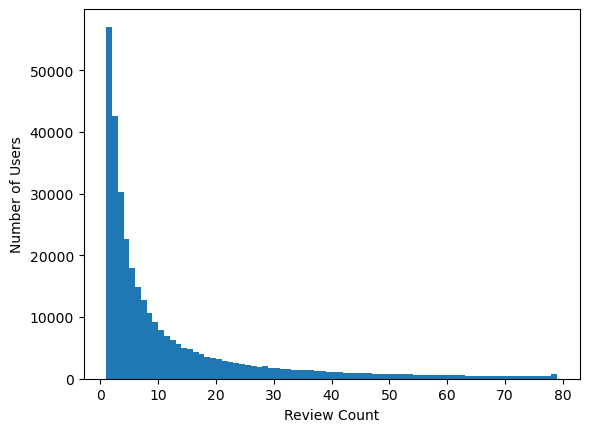

In [14]:
# TODO: Replace <FILL IN>

users_review_counts = users_rdd.map(lambda x:x['review_count']).collect()

plt.hist(users_review_counts, bins=range(1,80))
plt.xlabel('Review Count')
plt.ylabel('Number of Users')

** Question7: ** Plot the above histogram but now on a log-log scale using `bins=range(1,1000)`. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** Yes. Plotting a histogram on a log-log scale shows a linear relationship, which suggests a power law distribution. This is because the logarithm of the probability distribution function for a power law distribution is linear.

Text(0, 0.5, 'Number of Businesses')

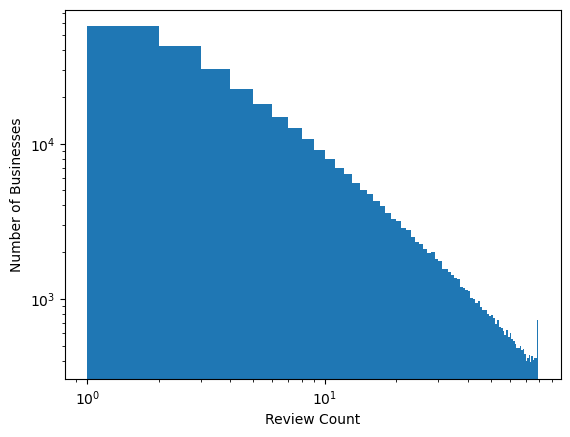

In [15]:
# TODO: Replace <FILL IN>

plt.hist(users_review_counts, bins=range(1,80))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Review Count')
plt.ylabel('Number of Businesses')

** Question8: ** Plot the histogram of number of friends a Yelp user has.

Text(0, 0.5, 'Number of Users')

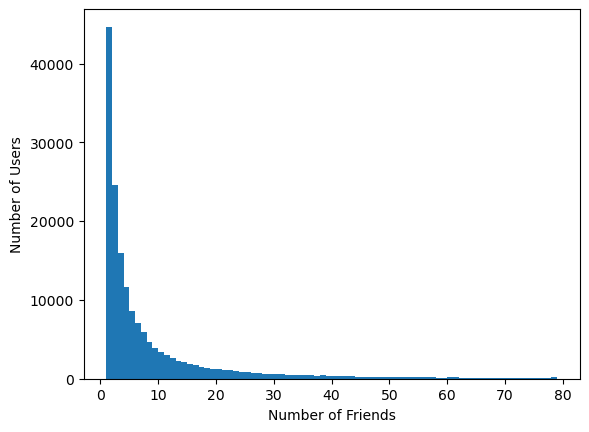

In [16]:
# TODO: Replace <FILL IN>

user_friend_counts = users_rdd.map(lambda x:len(x['friends'])).collect()

plt.hist(user_friend_counts, bins=range(1,80))
plt.xlabel('Number of Friends')
plt.ylabel('Number of Users')

** Question9: ** Plot the above histogram but now on a log-log scale. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** Yes. Plotting a histogram on a log-log scale shows a linear relationship, which suggests a power law distribution. This is because the logarithm of the probability distribution function for a power law distribution is linear.

Text(0, 0.5, 'Number of Users')

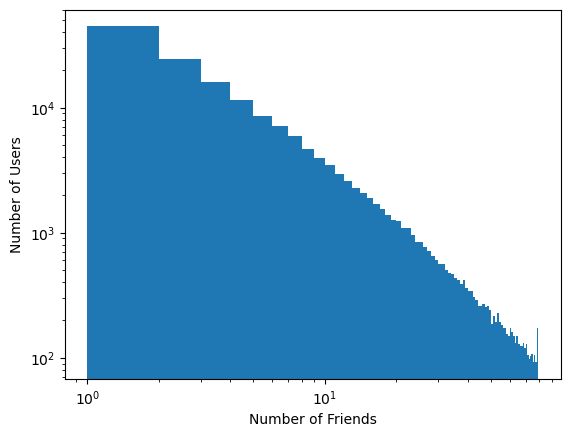

In [17]:
# TODO: Replace <FILL IN>

plt.hist(user_friend_counts, bins=range(1,80))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Friends')
plt.ylabel('Number of Users')

** Question10: ** Plot the histogram of number of fans a Yelp user has.

Text(0, 0.5, 'Number of Users')

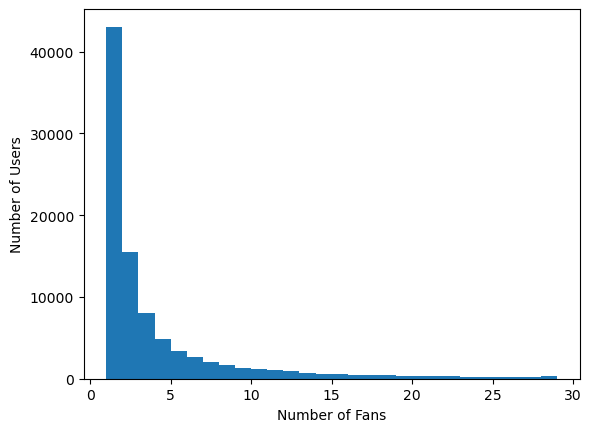

In [18]:
# TODO: Replace <FILL IN>

users_fan_counts = users_rdd.map(lambda x:x['fans']).collect()

plt.hist(users_fan_counts, bins=range(1,30))
plt.xlabel('Number of Fans')
plt.ylabel('Number of Users')

** Question11: ** Plot the above histogram but now on a log-log scale. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** Yes. Plotting a histogram on a log-log scale shows a linear relationship, which suggests a power law distribution. This is because the logarithm of the probability distribution function for a power law distribution is linear.

Text(0, 0.5, 'Number of Users')

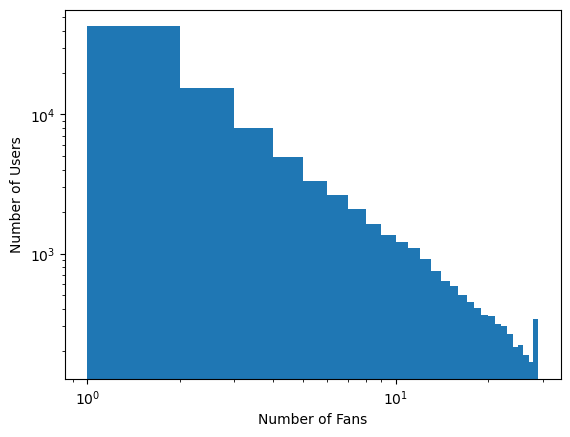

In [19]:
# TODO: Replace <FILL IN>

plt.hist(users_fan_counts, bins=range(1,30))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Fans')
plt.ylabel('Number of Users')

** Question12: ** Plot the histogram of number of checkins per Yelp business.

Text(0, 0.5, 'Number of Businesses')

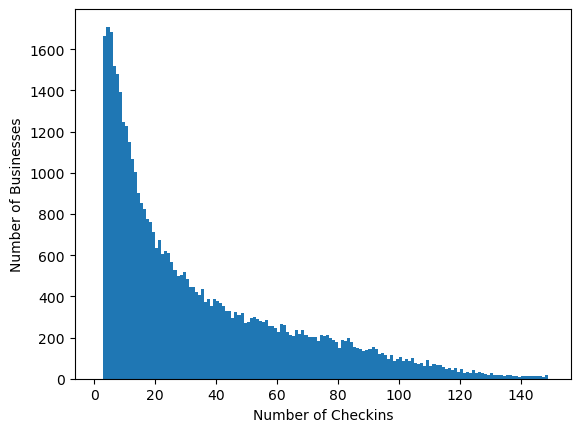

In [20]:
# TODO: Replace <FILL IN>

business_checkin_counts = checkins_rdd.map(lambda x:len(x['checkin_info'])).collect()

plt.hist(business_checkin_counts, bins=range(1,150))
plt.xlabel('Number of Checkins')
plt.ylabel('Number of Businesses')

** Question13: ** Plot the above histogram but now on a log-log scale using `bins=range(3,200)`. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** Yes. Plotting a histogram on a log-log scale shows a linear relationship, which suggests a power law distribution. This is because the logarithm of the probability distribution function for a power law distribution is linear.

Text(0, 0.5, 'Number of Businesses')

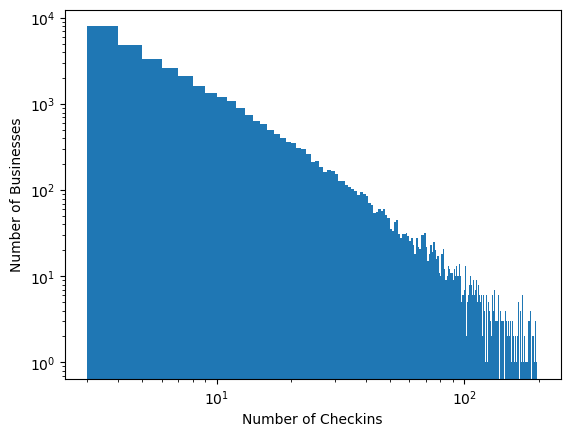

In [21]:
# TODO: Replace <FILL IN>

plt.hist(users_fan_counts, bins=range(3,200))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Checkins')
plt.ylabel('Number of Businesses')

** Question14: ** Find the maximum value of checkins per business. Filter to obtain business IDs of businesses that had these maximum number of checkins. Fill in the code required to carry out these steps.

In [22]:
# TODO: Replace <FILL IN>

max_checkin_count = checkins_rdd.map(lambda x:len(x['checkin_info'])).max()
business_ids_with_max_checkins = checkins_rdd \
    .filter(lambda x:len(x['checkin_info']) == max_checkin_count) \
    .map(lambda x:x['business_id']).collect()
len(business_ids_with_max_checkins)

41

In [23]:
# TODO: Replace <FILL IN>

business_names_with_max_checkins = businesses_rdd \
    .filter(lambda x:x['business_id'] in business_ids_with_max_checkins) \
    .map(lambda x: (x['name'], x['city'])).collect()
business_names_with_max_checkins

[('Charlotte Douglas International Airport', 'Charlotte'),
 ('Phoenix Sky Harbor International Airport', 'Phoenix'),
 ('Pho Kim Long', 'Las Vegas'),
 ('McCarran International Airport', 'Las Vegas'),
 ('The California Hotel & Casino', 'Las Vegas'),
 ('Golden Nugget Hotel & Casino', 'Las Vegas'),
 ('Rio All Suites Hotel & Casino', 'Las Vegas'),
 ('24 Hour Fitness', 'Las Vegas'),
 ('Excalibur Hotel', 'Las Vegas'),
 ('Ellis Island Casino & Brewery', 'Las Vegas'),
 ('Las Vegas Athletic Club', 'Las Vegas'),
 ('Orleans Hotel & Casino', 'Las Vegas'),
 ('Palms Casino Resort', 'Las Vegas'),
 ('Bellagio Hotel', 'Las Vegas'),
 ('New York - New York', 'Las Vegas'),
 ('Paris Las Vegas Hotel & Casino', 'Las Vegas'),
 ('Monte Carlo Hotel And Casino', 'Las Vegas'),
 ('The Venetian Resort Hotel Casino', 'Las Vegas'),
 ('The Mirage', 'Las Vegas'),
 ('MGM Grand Hotel', 'Las Vegas'),
 ('Treasure Island, LLC', 'Las Vegas'),
 ('The Peppermill Restaurant & Fireside Lounge', 'Las Vegas'),
 ('Flamingo Las Vegas

** Question15: ** Why do you think the above list sees much higher checkins than other businesses in the dataset?

** Answer: ** The list above consists of businesses that are primarily located in Las Vegas, with the exception of a few businesses in Charlotte and Phoenix. There are several factors that could contribute to why businesses in Las Vegas see much higher check-ins than other businesses in the dataset, such as being located in a popular area that attracts a lot of foot traffic or tourists, having a larger social media presence or more active following, or investing more in marketing or advertising to attract customers. Additionally, as many of the businesses on the list are casinos, hotels, or entertainment venues, it is possible that they benefit from the overall reputation of Las Vegas as a hub for entertainment and tourism. It's also possible that the unique atmosphere and culture of Las Vegas encourages people to check-in and share their experiences, either through social media or by using apps like Yelp.

** Question16: ** Plot a histogram of the stars associated with business reviews.

Text(0, 0.5, 'Number of Reviews')

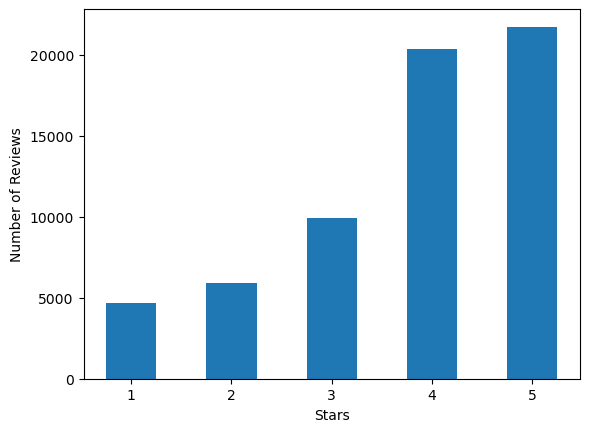

In [24]:
# TODO: Replace <FILL IN>

review_stars_counts = reviews_rdd.map(lambda x:x['stars']).collect()
plt.hist(review_stars_counts, bins=[x/2-0.25 for x in range(2, 12)])
plt.xlabel('Stars')
plt.ylabel('Number of Reviews')

** Question17: ** Plot a histogram of the number of reviews written per Yelp user.

Text(0, 0.5, 'Number of Users')

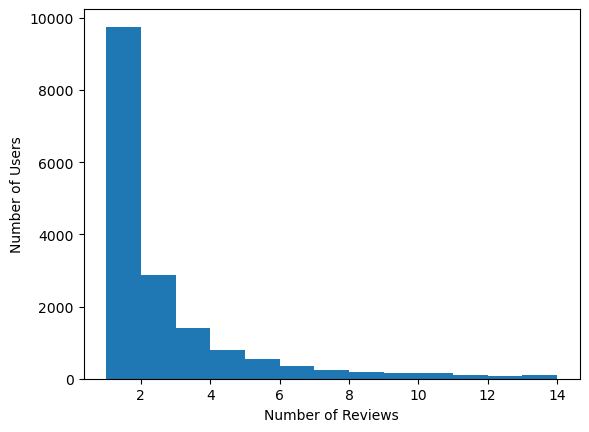

In [25]:
# TODO: Replace <FILL IN>

user_review_counts = list(reviews_rdd.map(lambda x:x['user_id']).countByValue().values())

plt.hist(user_review_counts, bins=[x for x in range(1, 15)])
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Users')

** Question18: ** Plot a histogram of the number of reviews written per Yelp business.

Text(0, 0.5, 'Number of Businesses')

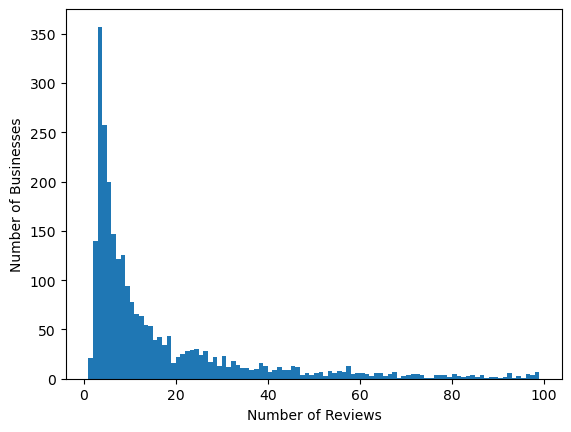

In [26]:
# TODO: Replace <FILL IN>

business_review_counts = list(reviews_rdd.map(lambda x:x['business_id']).countByValue().values())

plt.hist(business_review_counts, bins=[x for x in range(1, 100)])
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Businesses')

** Question19: ** Plot a histogram of the number of useful votes received by Yelp reviews.

Text(0, 0.5, 'Number of Reviews')

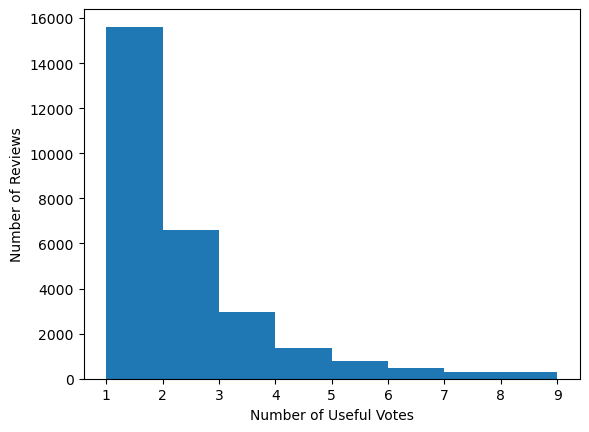

In [27]:
# TODO: Replace <FILL IN>

review_useful_counts = reviews_rdd.map(lambda x:x['votes']['useful']).collect()

plt.hist(review_useful_counts, bins=[x for x in range(1, 10)])
plt.xlabel('Number of Useful Votes')
plt.ylabel('Number of Reviews')

** Question20: ** Plot a histogram of the number of funny votes received by Yelp reviews.

Text(0, 0.5, 'Number of Reviews')

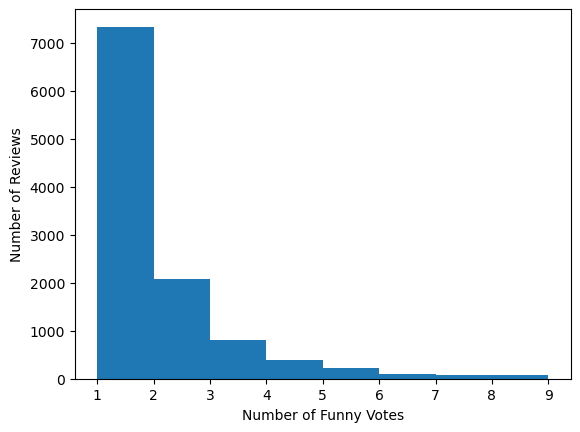

In [28]:
# TODO: Replace <FILL IN>

review_funny_counts = reviews_rdd.map(lambda x:x['votes']['funny']).collect()

plt.hist(review_funny_counts, bins=[x for x in range(1, 10)])
plt.xlabel('Number of Funny Votes')
plt.ylabel('Number of Reviews')

** Question21: ** Plot a histogram of the number of cool votes received by Yelp reviews.

Text(0, 0.5, 'Number of Reviews')

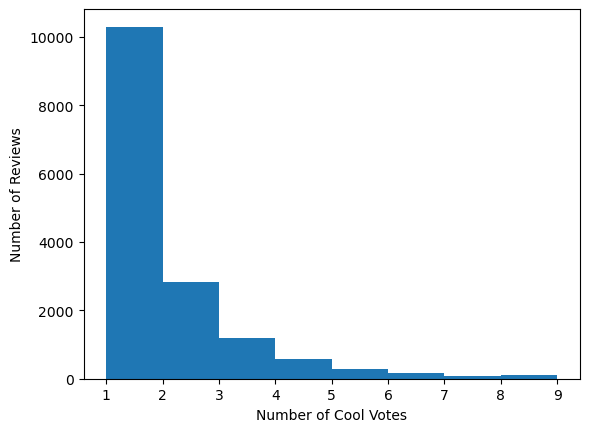

In [29]:
# TODO: Replace <FILL IN>

review_cool_counts = reviews_rdd.map(lambda x:x['votes']['cool']).collect()

plt.hist(review_cool_counts, bins=[x for x in range(1, 10)])
plt.xlabel('Number of Cool Votes')
plt.ylabel('Number of Reviews')

** Question22: ** Plot a pair-plot of the number of useful, funny, and cool votes received by Yelp reviews alongwith the stars associated with the review and the length of the review.

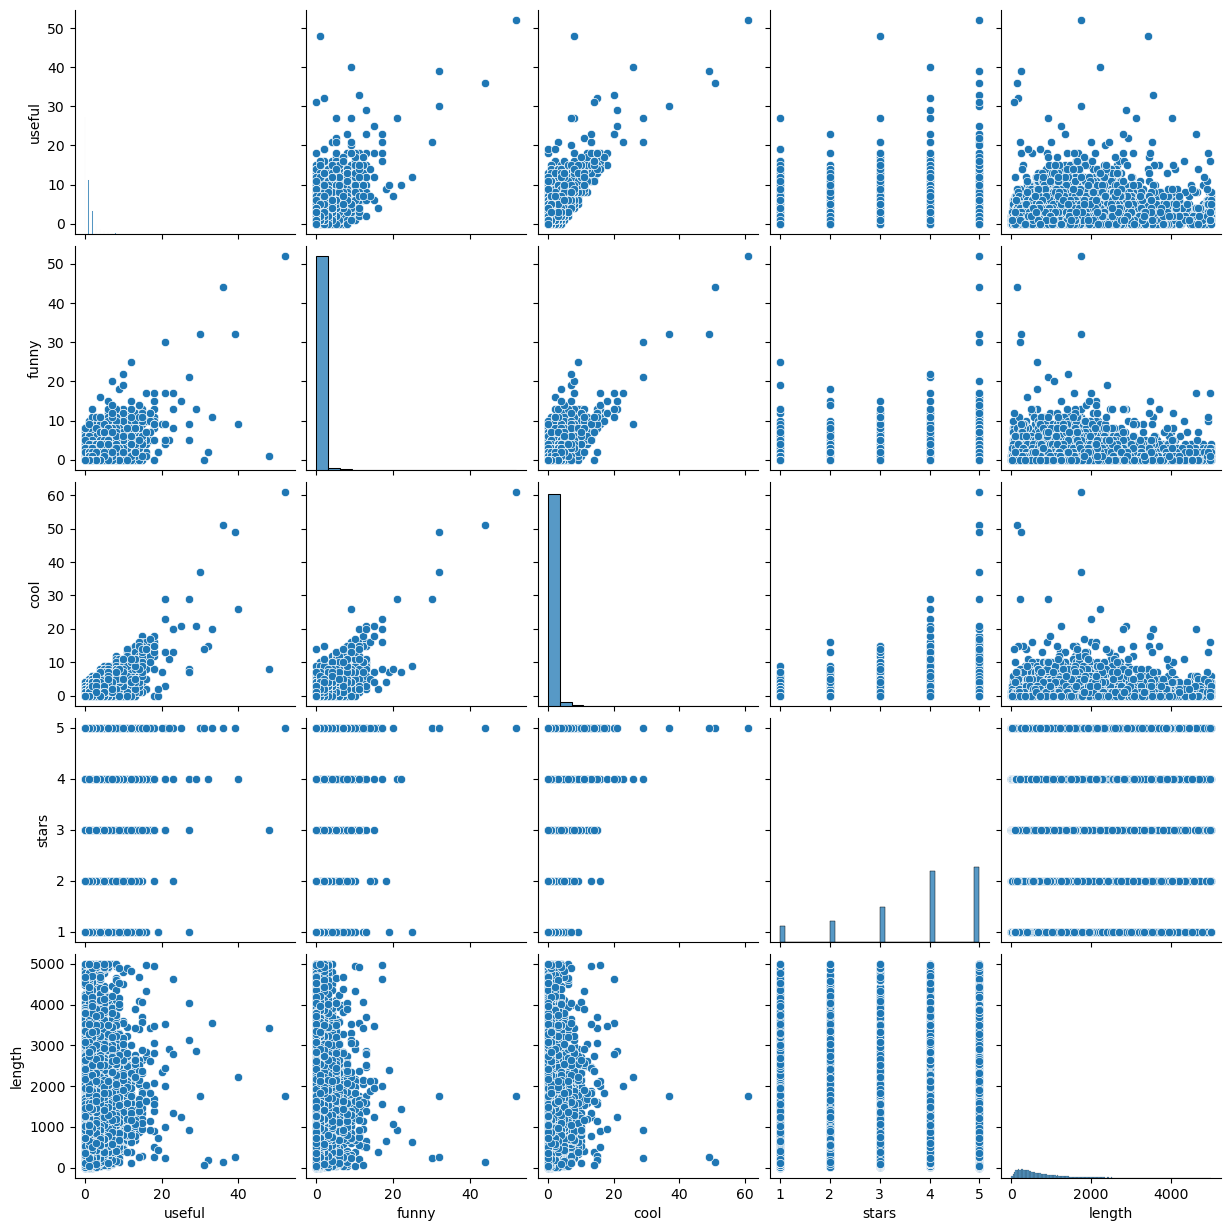

In [30]:
# TODO: Replace <FILL IN>

review_votes_length = reviews_rdd.map(lambda x: (x['votes']['useful'], x['votes']['funny'], x['votes']['cool'], x['stars'], len(x['text']))).collect()
review_votes_length_df = pd.DataFrame(review_votes_length, columns=['useful', 'funny', 'cool', 'stars', 'length'])
sns.pairplot(review_votes_length_df)

** Question23: ** Let us plot the distribution of the number of words used by males and females in their reviews. We will use the lists "male_names" and "female_names" we had created earlier for this purpose. Let's first find the user IDs associated with males and females.

In [31]:
# TODO: Replace <FILL IN>

male_users = users_rdd.filter(lambda x:x['name'] in male_names)
female_users = users_rdd.filter(lambda x:x['name'] in female_names)

male_user_ids = male_users.map(lambda x:x['user_id']).collect()
female_user_ids = female_users.map(lambda x:x['user_id']).collect()

print (len(male_user_ids))
print (len(female_user_ids))
print (users_rdd.count())

166682
174869
366715


** Question24: ** We can now use the user ID lists to separate the reviews into those by males and females and calculate the length of each review.

In [32]:
# TODO: Replace <FILL IN>

male_reviews = reviews_rdd.filter(lambda x:x['user_id'] in male_user_ids).map(lambda x : x['text'])
female_reviews = reviews_rdd.filter(lambda x:x['user_id'] in female_user_ids).map(lambda x : x['text'])

male_word_count = male_reviews.map(lambda x:len(x))
female_word_count = female_reviews.map(lambda x:len(x))

print ('Male and female review length averages: ', male_word_count.mean(), female_word_count.mean())

Male and female review length averages:  697.3215248363491 760.4281720764104


** Question25: ** The code below calculates the distributions of review lengths for males and female reviewers and plots them. Do you see a marked difference between the average review length of male and female reviewers? Are there any major trends or differences between the distributions of review length of male and female reviewers?

** Answer: ** The pair plot indicates that females tend to write longer reviews than males, as the ratio of number of reviews to number of words is higher in the female dimension than in the male dimension. Additionally, for both males and females, the trend shows an initial increase followed by a decrease as the length of the review increases.

In [33]:
male_word_distribution = list(male_word_count.map(lambda x : (x,1)).countByKey().items())
female_word_distribution = list(female_word_count.map(lambda x : (x,1)).countByKey().items())

male_word_distribution = sorted(male_word_distribution, key=lambda x: x[0])
female_word_distribution = sorted(female_word_distribution, key=lambda x: x[0])

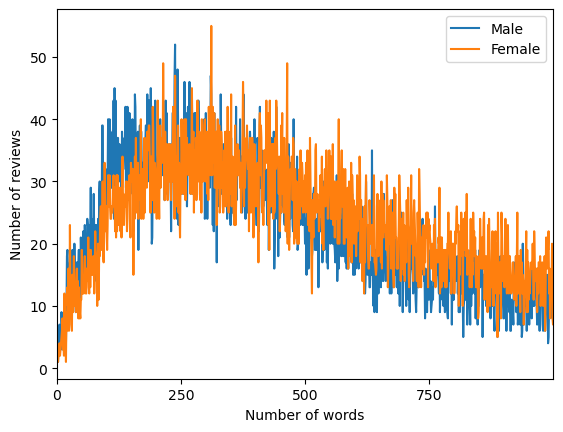

In [34]:
fig, ax = plt.subplots()
ax.plot([x[0] for x in male_word_distribution], [x[1] for x in male_word_distribution], label = 'Male')
ax.plot([x[0] for x in female_word_distribution], [x[1] for x in female_word_distribution], label = 'Female')

ax.set_xlim((0, 1000))
ax.set_xticks([0, 250, 500, 750])
ax.set_xticklabels(['0', '250','500','750'])

plt.xlabel('Number of words')
plt.ylabel('Number of reviews')
plt.legend()

# ** Part 2: Classification using tree ensemble methods **

In this section, we will predict the number of funny votes that a review has earned, indicating how funny readers found the review.

In [35]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.linalg import Vectors, DenseVector, SparseVector
from pyspark.mllib.regression import LabeledPoint

** Question1: ** Fill in the necessary code to calculate word counts from text reviews below.

In [36]:
# TODO: Replace <FILL IN>

max_words = 50000

all_reviews = reviews_rdd.map(lambda x : (x['text'], x['votes']['funny']))
word_counts = list(all_reviews.flatMap(lambda x:x[0].split(" ")).map(lambda x: (x,1)).countByKey().items())
word_counts = sorted(word_counts, key=lambda x: -x[1])

unique_words = [x[0] for x in word_counts[:max_words]]
num_unique_words = len(unique_words)
print('Number of unique words: ', num_unique_words)

Number of unique words:  50000


** Question2: ** We will now construct two dictionaries - one which maps from each word to a unique integer index and the second one which maps back from the index to the word. Write the code required to do this.

In [37]:
# TODO: Replace <FILL IN>

word_to_index_dict = {unique_words[i]:i for i in range(len(unique_words))}
index_to_word_dict = {i:unique_words[i] for i in range(len(unique_words))}

** Question3: ** Fill in the required code below to obtain a LabeledPoint RDD that can be used to train an mllib classifier/regressor.

In [38]:
# TODO: Replace <FILL IN>

doc_vectors = all_reviews.map(lambda x: (x[1], x[0].split())).map(lambda x: (x[0], [word_to_index_dict[w] for w in x[1] if w in word_to_index_dict]))
doc_vectors = doc_vectors.map(lambda x: LabeledPoint(x[0],SparseVector(num_unique_words,sorted(set(x[1])),[x[1].count(i) for i in sorted(set(x[1]))])))
# sorted(set(x[1])): a list of unique words in the document, sorted by index
# [x[1].count(i) for i in sorted(set(x[1]))]:create a list of the frequency of each unique word in the document

print(doc_vectors.count())
print(doc_vectors.take(2))

62608
[LabeledPoint(3.0, (50000,[0,1,2,4,7,9,10,12,13,16,17,20,21,26,39,43,49,56,86,105,113,125,163,167,193,204,232,282,293,302,339,347,358,359,465,485,658,659,673,752,765,930,982,995,1086,1118,1437,1887,2245,2375,2925,3646,3892,4104,4282,4631,4725,4726,4889,5276,5634,5912,6052,6383,7508,10225,14660,15114,15542,16604,16605,17198,26514,30902,33876,37766],[8.0,3.0,1.0,5.0,5.0,1.0,1.0,1.0,2.0,4.0,6.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])), LabeledPoint(1.0, (50000,[0,4,6,9,10,18,20,36,37,42,45,55,76,80,88,100,110,131,200,239,298,313,323,358,373,387,399,442,465,602,639,716,903,926,976,2925,3470,6464,6595,10371,15543,17810,22105],[2.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.

** Question4: ** Randomly split the doc_vectors RDD into 80% training and 20% validation data.

In [39]:
# TODO: Replace <FILL IN>

doc_vectors_train, doc_vectors_val = doc_vectors.randomSplit([0.8, 0.2], seed=42)

** Question5: ** Let us implement the baseline predictor which always outputs the most common value of funny votes. Fill in appropriate code.

In [40]:
# TODO: Replace <FILL IN>

most_common_prediction = sorted(doc_vectors_train.map(lambda lp:lp.label).countByValue().items(), key=lambda x:-x[1])[0][0]

# 'doc_vectors_train.map(lambda lp:lp.label)' maps the training data RDD to a new RDD with only the label values
# '.countByValue()' returns a dictionary of value counts for each label
# '.items()' returns a list of tuples, where each tuple contains a label and its corresponding count
# 'sorted(..., key=lambda x:-x[1])' sorts the list of tuples in descending order based on the count (second element in each tuple)
# [0][0] selects the label with the highest count (first element in the first tuple)

labels_and_predictions = doc_vectors_val.map(lambda lp: (lp.label, most_common_prediction))
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Baseline) = ' + str(val_mse))
print('Learned baseline prediction: ', most_common_prediction)

Validation Root Mean Squared Error (Baseline) = 1.1323880834793691
Learned baseline prediction:  0.0


** Question6: ** Let us now use a Decision Tree to predict the number of funny votes. Set the maximum depth of the tree to 5 and use an appropriate impurity metric for regression.

In [41]:
# TODO: Replace <FILL IN>

# reason for using 'variance' as impurity metric:
# In the context of regression, variance is an appropriate metrix becasue we are trying to predict a continuous numerical value 
# (in this case, the number of funny votes). Therefore, minimizing variance will result in creating splits that group together 
# data points with similar target values. This will help create a more accurate regressor. 

dt_model = DecisionTree.trainRegressor(doc_vectors_train, categoricalFeaturesInfo={}, impurity='variance',maxDepth=5)

predictions = dt_model.predict(doc_vectors_val.map(lambda x: x.features))
labels_and_predictions = doc_vectors_val.map(lambda lp: lp.label).zip(predictions)
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Decision Tree) = ' + str(val_mse))
print('Learned regression tree model:')
print(dt_model.toDebugString())

23/04/30 12:44:45 WARN DAGScheduler: Broadcasting large task binary with size 1153.9 KiB
23/04/30 12:44:55 WARN DAGScheduler: Broadcasting large task binary with size 1913.5 KiB
23/04/30 12:45:05 WARN DAGScheduler: Broadcasting large task binary with size 1914.4 KiB
23/04/30 12:45:10 WARN DAGScheduler: Broadcasting large task binary with size 1915.0 KiB
23/04/30 12:45:16 WARN DAGScheduler: Broadcasting large task binary with size 1915.8 KiB
23/04/30 12:45:21 WARN DAGScheduler: Broadcasting large task binary with size 1916.6 KiB
23/04/30 12:45:27 WARN DAGScheduler: Broadcasting large task binary with size 1289.8 KiB


Validation Root Mean Squared Error (Decision Tree) = 1.0708342745461825
Learned regression tree model:
DecisionTreeModel regressor of depth 5 with 25 nodes
  If (feature 23839 <= 1.5)
   If (feature 3 <= 6.5)
    If (feature 44095 <= 0.5)
     If (feature 34517 <= 0.5)
      If (feature 212 <= 4.0)
       Predict: 0.24270280515542078
      Else (feature 212 > 4.0)
       Predict: 21.0
     Else (feature 34517 > 0.5)
      If (feature 1 <= 12.5)
       Predict: 13.0
      Else (feature 1 > 12.5)
       Predict: 7.0
    Else (feature 44095 > 0.5)
     Predict: 32.0
   Else (feature 3 > 6.5)
    If (feature 6785 <= 1.5)
     If (feature 48352 <= 0.5)
      If (feature 271 <= 5.5)
       Predict: 0.6509638708030129
      Else (feature 271 > 5.5)
       Predict: 17.0
     Else (feature 48352 > 0.5)
      Predict: 22.0
    Else (feature 6785 > 1.5)
     If (feature 0 <= 12.5)
      Predict: 32.0
     Else (feature 0 > 12.5)
      Predict: 17.0
  Else (feature 23839 > 1.5)
   If (feature 0 <=

** Question7: ** Let us now use a Random Forest ensemble to predict the number of funny votes. Set the maximum depth of the tree to 5 and use an appropriate impurity metric for regression. Build a random forest regressor with 10 trees.

In [42]:
# TODO: Replace <FILL IN>

rf_model = RandomForest.trainRegressor(doc_vectors_train, categoricalFeaturesInfo={}, numTrees=10, impurity='variance', maxDepth=5)
predictions = rf_model.predict(doc_vectors_val.map(lambda x: x.features))
labels_and_predictions = doc_vectors_val.map(lambda lp: lp.label).zip(predictions)
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Random Forest) = ' + str(val_mse))
print('Learned regression RF model:')
print(rf_model.toDebugString())

23/04/30 12:45:46 WARN DAGScheduler: Broadcasting large task binary with size 1153.9 KiB
23/04/30 12:45:55 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
23/04/30 12:46:07 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/04/30 12:46:18 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/04/30 12:46:31 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
23/04/30 12:46:46 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
23/04/30 12:47:06 WARN DAGScheduler: Broadcasting large task binary with size 1317.2 KiB
23/04/30 12:47:17 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/04/30 12:47:17 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Validation Root Mean Squared Error (Random Forest) = 1.025266714969327
Learned regression RF model:
TreeEnsembleModel regressor with 10 trees

  Tree 0:
    If (feature 2 <= 5.5)
     If (feature 27005 <= 0.5)
      If (feature 9422 <= 1.5)
       If (feature 34517 <= 0.5)
        If (feature 42284 <= 0.5)
         Predict: 0.23197127541215737
        Else (feature 42284 > 0.5)
         Predict: 15.0
       Else (feature 34517 > 0.5)
        Predict: 13.0
      Else (feature 9422 > 1.5)
       Predict: 20.0
     Else (feature 27005 > 0.5)
      If (feature 3 <= 0.5)
       Predict: 32.0
      Else (feature 3 > 0.5)
       Predict: 0.0
    Else (feature 2 > 5.5)
     If (feature 26948 <= 0.5)
      If (feature 1071 <= 5.5)
       If (feature 17044 <= 0.5)
        If (feature 30191 <= 0.5)
         Predict: 0.5666906993511175
        Else (feature 30191 > 0.5)
         Predict: 5.875
       Else (feature 17044 > 0.5)
        If (feature 119 <= 0.5)
         Predict: 2.5714285714285716
  

** Question8: ** Let us now use a Gradient Boosting Trees (GBT) ensemble to predict the number of funny votes. Set the maximum number of iterations to 10. Does this affect the number of trees in the ensemble? Do we need to set the maximum depth of trees in the ensemble? Why or why not?

** Answer: ** 

**Yes, setting the maximum number of iterations to 10 affects the number of trees in the ensemble model.** In Gradient Boosting Trees (GBT), the number of iterations refers to the number of trees in the ensemble. So, setting the maximum number of iterations to 10 does affect the number of trees in the ensemble, as there will be 10 trees in the model. Each tree is built to correct the errors of the previous tree. So, increasing the number of iterations (or trees) allows the algorithm to fit the data more closely. However, adding too many trees can lead to overfitting, which means that the model may not generalize well to new, unseen data.

The maximum depth of trees determines how complex each tree is allowed to be. A deeper tree can capture more complex interactions between features, but can also lead to overfitting. Setting a maximum depth can help control the complexity of the trees and prevent overfitting. **However, we don't necessarily need to set the maximum depth of trees in the ensemble, as the algorithm will automatically control the complexity of each tree during training.** The GBT algorithm includes a built-in regularization mechanism that prevents overfitting by controlling the size and complexity of the trees in the ensemble.

In [43]:
# TODO: Replace <FILL IN>

gb_model = GradientBoostedTrees.trainRegressor(doc_vectors_train,
                                               categoricalFeaturesInfo={},
                                               numIterations=10,
                                               learningRate=0.1) # default learning rate

predictions = gb_model.predict(doc_vectors_val.map(lambda x: x.features))
labels_and_predictions = doc_vectors_val.map(lambda lp: lp.label).zip(predictions)
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Gradient Boosting Trees) = ' + str(val_mse))
print('Learned regression GBT model:')
print(gb_model.toDebugString())

23/04/30 12:47:30 WARN DAGScheduler: Broadcasting large task binary with size 1154.1 KiB
23/04/30 12:47:40 WARN DAGScheduler: Broadcasting large task binary with size 1914.9 KiB
23/04/30 12:47:46 WARN DAGScheduler: Broadcasting large task binary with size 1915.8 KiB
23/04/30 12:47:51 WARN DAGScheduler: Broadcasting large task binary with size 1916.4 KiB
23/04/30 12:47:57 WARN DAGScheduler: Broadcasting large task binary with size 1922.8 KiB
23/04/30 12:48:01 WARN DAGScheduler: Broadcasting large task binary with size 1923.4 KiB
23/04/30 12:48:07 WARN DAGScheduler: Broadcasting large task binary with size 1924.0 KiB
23/04/30 12:48:12 WARN DAGScheduler: Broadcasting large task binary with size 1926.0 KiB
23/04/30 12:48:17 WARN DAGScheduler: Broadcasting large task binary with size 1926.6 KiB
23/04/30 12:48:22 WARN DAGScheduler: Broadcasting large task binary with size 1927.3 KiB
23/04/30 12:48:28 WARN DAGScheduler: Broadcasting large task binary with size 1928.9 KiB
23/04/30 12:48:33 WAR

Validation Root Mean Squared Error (Gradient Boosting Trees) = 1.0585167899324488
Learned regression GBT model:
TreeEnsembleModel regressor with 10 trees

  Tree 0:
    If (feature 23839 <= 1.5)
     If (feature 3 <= 6.5)
      If (feature 44095 <= 0.5)
       Predict: 0.24426124653542747
      Else (feature 44095 > 0.5)
       Predict: 32.0
     Else (feature 3 > 6.5)
      If (feature 6785 <= 1.5)
       Predict: 0.6557753669432036
      Else (feature 6785 > 1.5)
       Predict: 24.5
    Else (feature 23839 > 1.5)
     If (feature 0 <= 19.5)
      Predict: 52.0
     Else (feature 0 > 19.5)
      If (feature 18 <= 3.5)
       Predict: 8.0
      Else (feature 18 > 3.5)
       Predict: 2.0
  Tree 1:
    If (feature 34517 <= 0.5)
     If (feature 18 <= 2.5)
      If (feature 212 <= 4.0)
       Predict: -0.06725853351449661
      Else (feature 212 > 4.0)
       Predict: 41.51147750692917
     Else (feature 18 > 2.5)
      If (feature 21421 <= 0.5)
       Predict: 0.5700469379381172
      

** Question9: ** Which of the four methods we tried gave the best validation RMSE results? 

** Answer: ** 
Validation Root Mean Squared Error (Decision Tree) = 1.2747401683904578
Validation Root Mean Squared Error (Random Forest) = 1.2193139106492852
Validation Root Mean Squared Error (Gradient Boosting Trees) = 1.2103222214514662

We can see that Gradient Boosting Trees has the smallest Validation Root Mean Squared Error, thus it has the best result. However, based on the results obtained, it can be observed that the Random Forest model gave a validation RMSE almost as good as Gradient Boosting Trees.

# ** Part 3: Collaborative filtering for recommendation **

In this section, we will tackle a [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) task which can be used to recommend businesses to users based on the ratings they have already assigned to some businesses they have visited.

In [44]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

** Question1: ** Let us first determine the unique user and business IDs that appear in the reviews data. This will help us build dictionaries for mapping the user/business IDs to unique integer indices. Fill in the required code to build these dictionaries below.

In [45]:
# TODO: Replace <FILL IN>

review_user_ids = reviews_rdd.map(lambda x:x['user_id']).distinct().collect()
review_business_ids = reviews_rdd.map(lambda x:x['business_id']).distinct().collect()

user_to_index_dict = {review_user_ids[i]: i for i in range(len(review_user_ids))}
business_to_index_dict = {review_business_ids[i]: i for i in range(len(review_business_ids))}

** Question2: ** Next, transform each review into a rating. The Rating object takes a unique user index, a unique business index, and float-valued rating.

In [46]:
# TODO: Replace <FILL IN>

ratings_rdd = reviews_rdd.map(lambda x: Rating(user_to_index_dict[x['user_id']], 
                                               business_to_index_dict[x['business_id']], 
                                               float(x['stars'])))
print(ratings_rdd.take(2))

[Rating(user=15903, product=910, rating=5.0), Rating(user=11610, product=910, rating=2.0)]


** Question3: ** Let us randomly split data into 80% train and 20% validation set.

In [47]:
# TODO: Replace <FILL IN>

ratings_rdd_train, ratings_rdd_val = ratings_rdd.randomSplit([0.8, 0.2], seed=42)

** Question4: ** For a succession of ranks, we will now build an collaborative filtering algorithm using ALS (Alternating Least Squares). We will use the model to obtain train as well as validation RMSE for each rank. In the cell below, you can fill in the code to carry out the model-building, prediction, and RMSE calculation.

Note fo myself: The 'rank' hyperparameter specifies the number of latent factors to use in the matrix factorization mdoel.

A larger value of rank typically leads to a more expressive model, but it may also result in overfitting and slower training times. On the other hand, a smaller value of rank may lead to a simpler model that is more prone to underfitting. 

Therefore, 'rank is a hyperparameter that should be tuned to achieve the best performance of the model on the validation set.

In [48]:
# TODO: Replace <FILL IN>

numIterations=10
ranks = list(range(1,20)) + list(range(20, 201, 20))
train_rmses = []
val_rmses = []

for rank in ranks:
    cf_model = ALS.train(ratings_rdd_train, rank, numIterations)
    
    train_data = ratings_rdd_train.map(lambda p: (p[0], p[1]))
    predictions = cf_model.predictAll(train_data).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = ratings_rdd_train.map(lambda r: ((r[0], r[1]), r[2])).join(predictions) #join is used to combine two RDDs based on their keys
    train_rmse = np.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    train_rmses.append(train_rmse)
    
    val_data = ratings_rdd_val.map(lambda p: (p[0], p[1]))
    predictions = cf_model.predictAll(val_data).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = ratings_rdd_val.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    val_rmse = np.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    val_rmses.append(val_rmse)
    
    print("Root Mean Squared Error (rank={}) = Train {}, Validation {}".format(rank, train_rmse, val_rmse))

23/04/30 12:51:10 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/04/30 12:51:10 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
23/04/30 12:51:52 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB
23/04/30 12:51:58 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB


Root Mean Squared Error (rank=1) = Train 2.6280055511566545, Validation 10.452185830805453


23/04/30 12:52:55 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB
23/04/30 12:53:01 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB


Root Mean Squared Error (rank=2) = Train 0.8673273492699088, Validation 3.857384973293694


23/04/30 12:53:59 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 12:54:05 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=3) = Train 0.6045944615219769, Validation 2.3846703606832356


23/04/30 12:55:06 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 12:55:12 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=4) = Train 0.5385555608674437, Validation 2.404785070724591


23/04/30 12:56:11 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 12:56:17 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=5) = Train 0.482262710095724, Validation 2.3555625090093124


23/04/30 12:57:17 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 12:57:24 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=6) = Train 0.43265143177611926, Validation 2.2578810663496918


23/04/30 12:58:23 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 12:58:29 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=7) = Train 0.4072951054061643, Validation 2.2277768907247006


23/04/30 12:59:27 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 12:59:32 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=8) = Train 0.38029903437211676, Validation 2.28695742605952


23/04/30 13:00:33 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 13:00:39 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=9) = Train 0.3505287290558129, Validation 2.277210001715466


23/04/30 13:01:36 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 13:01:45 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=10) = Train 0.3214466433383613, Validation 2.0841536325265557


23/04/30 13:02:43 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 13:02:49 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=11) = Train 0.30701492090263255, Validation 2.1043424652497915


23/04/30 13:03:50 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 13:03:56 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=12) = Train 0.2864437393864442, Validation 2.085314166533563


23/04/30 13:04:54 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 13:05:00 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=13) = Train 0.2724487814672371, Validation 2.1397091686857164


23/04/30 13:06:02 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 13:06:08 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=14) = Train 0.25845927372539856, Validation 2.0042791410690466


23/04/30 13:07:07 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 13:07:12 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=15) = Train 0.24914460529975324, Validation 1.9930088622966868


23/04/30 13:08:14 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 13:08:21 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=16) = Train 0.23772556748789067, Validation 2.089257622805312


23/04/30 13:09:21 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 13:09:27 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=17) = Train 0.22898246385702883, Validation 1.9652671597498939


23/04/30 13:10:26 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 13:10:32 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=18) = Train 0.22407433118021886, Validation 1.9197785958562879


23/04/30 13:11:31 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 13:11:37 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=19) = Train 0.2171331092732357, Validation 1.946436495660339


23/04/30 13:12:39 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 13:12:44 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=20) = Train 0.2108248035923398, Validation 1.9359199012146195


23/04/30 13:13:45 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 13:13:50 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=40) = Train 0.1828306381761671, Validation 1.7599504090205789


23/04/30 13:14:47 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 13:14:53 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=60) = Train 0.1806981248772333, Validation 1.6677449054397744


23/04/30 13:15:54 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 13:16:00 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=80) = Train 0.18019207521534553, Validation 1.6191755157492551


23/04/30 13:16:57 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 13:17:03 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=100) = Train 0.18009287627518009, Validation 1.592456463913621


23/04/30 13:18:04 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 13:18:10 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=120) = Train 0.1799103673953627, Validation 1.5914703141126183


23/04/30 13:19:08 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 13:19:14 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=140) = Train 0.17982188671528887, Validation 1.5839503530333654


23/04/30 13:20:13 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 13:20:19 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=160) = Train 0.17984113845312458, Validation 1.574810449931767


23/04/30 13:21:17 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 13:21:23 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=180) = Train 0.17985654675048793, Validation 1.571823672081094


23/04/30 13:22:25 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 13:22:31 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=200) = Train 0.1798283814655954, Validation 1.567114041729214


** Question5: ** Let us plot the train and validation RMSE versus the rank. The code below does this for you. Based on this plot, what would your choice of the rank hyperparameter be? Is this choice conclusive or do we need to conduct a more extensive hyperparameter search at larger ranks than the ones we have evaluated?

** Answer: ** Based on the plot, it seems like the validation RMSE decreases as we increase the rank up to a certain point (around rank = 25), but then it starts to plateau. The optimal rank appears to be around 75~100, where the validation RMSE reaches its minimum. However, it is possible that a more extensive hyperparameter search at larger ranks might yield even better results. Therefore, it is always a good practice to try different hyperparameters and validate the results.

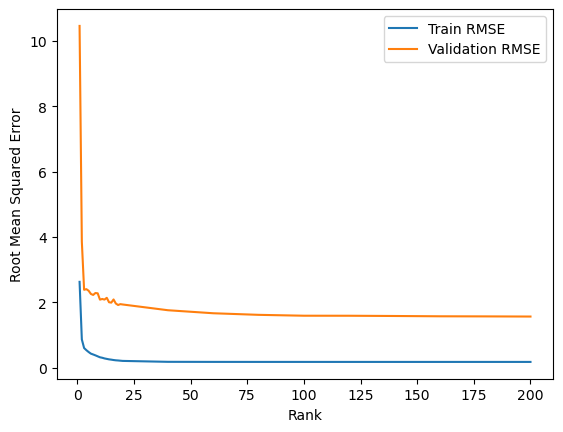

In [49]:
fig, ax = plt.subplots()
ax.plot(ranks, train_rmses, label='Train RMSE')
ax.plot(ranks, val_rmses, label='Validation RMSE')

plt.xlabel('Rank')
plt.ylabel('Root Mean Squared Error')
plt.legend()

# ** Part 4: Topic modeling for text reviews **

In this section, we will build and examine a Bayesian topic model named [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation). The goal of textual topic modeling is to discover latent topics whose mixtures generate textual documents through a stylized probabilistic generatve model. The topics often have semantic meaning. They may be associated with various aspects discussed in the text corpus such as politics, health, education, etc. Topic models are unsupervised machine learning algorithms. Hence, the nature of discovered topics is entirely dependent of the context of your dataset.

In [50]:
from pyspark.mllib.linalg import Vectors, DenseVector, SparseVector
from pyspark.mllib.clustering import LDA, LDAModel

** Question1: ** Let us create a new RDD of just textual reviews from reviews_rdd, obtain word counts, and build a list of unique words that do not include stop words. Use num_stop_words as a measure of how many of the most frequent words to filter out.

In [51]:
# TODO: Replace <FILL IN>

# number of stopwords i.e. most frequent words to remove
# removal of stopwords such as a, the, from, etc. that occur across a vast majority of documents improves topic models
num_stop_words = 1000

all_reviews = reviews_rdd.map(lambda x:x['text'])
word_counts = list(all_reviews.flatMap(lambda x: x.lower().split()).map(lambda x: (x,1)).countByKey().items())
# sort words in descending order of frequency
word_counts = sorted(word_counts, key=lambda x:-x[1]) 

# remove stopwords
unique_words = [x[0] for x in word_counts[num_stop_words:]]
num_unique_words = len(unique_words)
print('Number of unique words: ', num_unique_words)

Number of unique words:  192742


** Question2: ** We will now construct two dictionaries - one which maps from each word to a unique integer index and the second one which maps back from the index to the word. Write the code required to do this.

In [52]:
# TODO: Replace <FILL IN>

word_to_index_dict = {unique_words[i]:i for i in range(len(unique_words))}
index_to_word_dict = {i:unique_words[i] for i in range(len(unique_words))}

** Question3: ** Construct an RDD of SparseVectors. Each SparseVector is built using the word counts of a review. Hence, the RDD of SparseVectors should be obtained as a map from the RDD of document word counts.

In [53]:
# TODO: Replace <FILL IN>

doc_vectors = all_reviews.map(lambda x: x.lower().split()).map(lambda x: [word_to_index_dict[w] for w in x if w in word_to_index_dict])
doc_vectors = doc_vectors.map(lambda x: SparseVector(num_unique_words, sorted(set(x)), [x.count(i) for i in sorted(set(x))]))
# zipWithIndex result needs a minor transform to be acceptable to the LDA training procedure
doc_vectors = doc_vectors.zipWithIndex().map(lambda x:[x[1], x[0]])
print(doc_vectors.count())
print(doc_vectors.take(2))

62608
[[0, SparseVector(192742, {8: 2.0, 114: 1.0, 311: 1.0, 1209: 1.0, 1315: 1.0, 1444: 1.0, 1805: 1.0, 1987: 1.0, 2249: 1.0, 2738: 1.0, 2965: 1.0, 3148: 1.0, 3166: 1.0, 3530: 1.0, 3614: 1.0, 3977: 1.0, 4305: 1.0, 4391: 1.0, 4700: 1.0, 6041: 1.0, 8947: 1.0, 11064: 1.0, 13456: 1.0, 14371: 1.0, 23207: 1.0, 54812: 1.0, 77509: 1.0, 77510: 1.0, 77511: 1.0, 77512: 1.0})], [1, SparseVector(192742, {1805: 1.0, 2231: 1.0, 4799: 1.0, 5281: 1.0, 8776: 1.0, 12656: 1.0, 15459: 1.0, 17524: 1.0})]]


** Question4: ** Train an LDA model with a 100 topics and the random seed set to 42.

In [54]:
# TODO: Replace <FILL IN>

lda_model = LDA.train(doc_vectors, k=100, seed=42)

** Question5: ** Display the LDA model vocabulary size.

In [55]:
# TODO: Replace <FILL IN>

print('Model vocabulary size: ', lda_model.vocabSize())

Model vocabulary size:  192742


** Question6: ** Display 5 learned topics and the top 100 terms that appear in each of these topics. Assign a semantic label/meaning to each of them (e.g. food, ambience, drinks, service, etc.) You can access the topic matrix using the function topicsMatrix on the model. Do the topics learned from Yelp reviews look representative of the corpus?

In [56]:
# TODO: Replace <FILL IN>

topics = lda_model.topicsMatrix()

for i in range(5):
    index = lda_model.describeTopics(100)[i][0]
    print(i)
    print([index_to_word_dict[x] for x in index])


0
['charge', 'up,', 'bottom', 'true', 'pancakes', "you'd", 'great!', 'thick', 'covered', 'choices', 'limited', 'paying', 'best.', 'generally', 'times.', 'orders', 'stayed', 'sign', 'thinking', 'forget', 'wall', 'thank', 'room.', 'pizza,', 'sour', 'pepper', 'general', 'card', 'somewhere', 'life', 'recommended', 'please', 'meal,', 'hand', 'penn', 'area,', 'right.', 'location.', 'tasty,', 'atmosphere,', 'is,', 'personal', 'chili', 'mine', 'minute', 'pricey', 'seriously', 'avoid', 'terrible', 'clearly', 'finished', 'noodle', 'employees', 'share', 'inside.', 'town.', 'greasy', 'small,', 'visit.', 'means', 'except', "they've", 'else.', 'you,', 'dogs', 'dressing', "we're", 'apple', 'side,', 'station', 'rooms', 'bread.', 'original', 'total', 'oakland', 'special.', 'works', 'okay,', '...', 'cook', 'picked', 'them,', 'waffle', 'kinda', '(not', 'and,', 'perfect.', 'fresh.', 'nearly', 'amazing!', 'selection.', 'play', ',', 'bean', 'oil', 'thin', 'longer', 'bunch', 'minutes.', 'recent']


1
['choices', 'covered', 'general', 'pepper', 'thick', 'bean', 'bottom', 'charge', 'finished', 'room.', 'up,', 'times.', 'sign', 'tasty,', 'wall', 'best.', "you'd", 'true', 'paying', 'somewhere', 'side,', 'generally', 'forget', 'sour', 'except', 'clearly', 'limited', 'pricey', 'please', 'pancakes', 'personal', 'seriously', 'apple', 'thank', 'dressing', "they've", 'meal,', 'great!', 'small,', 'creamy', 'mine', 'cook', 'oil', 'atmosphere,', 'employees', 'means', 'selection.', 'hand', 'amazing!', 'special.', 'chili', 'perfect.', 'honestly', 'minutes.', 'thin', 'share', 'recent', 'bread.', 'penn', 'you,', 'greasy', 'longer', 'terrible', 'recommended', 'visit.', 'supposed', 'noodle', 'okay,', 'thinking', 'life', 'byob', 'toast', 'total', 'pizza,', 'fresh.', 'and,', 'else.', 'delivery', 'town.', 'is,', 'area,', 'rooms', ',', "we're", 'hostess', 'la', 'location.', 'credit', 'nearly', 'fat', 'corner', 'minute', 'oh,', 'orders', 'right.', 'inside.', '(not', 'whatever', 'picked', 'burrito']


2
['choices', 'bean', 'burrito', 'limited', 'covered', 'somewhere', "you'd", 'great!', 'thick', 'thin', 'paying', 'finished', 'up,', 'true', 'general', 'charge', 'share', 'pepper', 'sour', 'best.', 'pancakes', 'wall', 'noodle', 'oil', 'bottom', 'please', 'atmosphere,', 'generally', 'mine', 'fresh.', 'tasty,', 'dressing', 'creamy', 'burger.', 'pizza,', 'forget', 'side,', 'orders', 'perfect.', 'seriously', 'times.', 'recommended', 'wait.', 'except', 'hand', 'inside.', 'thank', 'smaller', 'meal,', 'toast', 'is,', 'greasy', 'la', 'chili', 'apple', 'sign', 'special.', 'clearly', 'small,', 'thinking', 'them,', 'bread.', 'drink.', 'whatever', 'life', 'else.', 'area,', 'supposed', 'honestly', "they've", 'and,', '...', 'cook', 'options.', 'bunch', 'employees', 'byob', 'waffle', 'banana', 'delivery', 'nearly', 'back!', 'yummy', 'minute', 'total', 'means', "we're", 'hostess', 'minutes.', 'terrible', 'avoid', 'you,', 'penn', 'slice', 'personal', 'slices', 'amazing!', 'pricey', 'barely', 'recent']


3
['noodle', 'bean', 'sour', 'pepper', 'is,', 'generally', 'best.', 'paying', 'dressing', 'up,', 'thick', 'share', 'wall', 'burrito', 'finished', 'except', 'tasty,', 'inside.', 'choices', 'pancakes', 'thank', 'avoid', 'creamy', 'special.', "we're", 'charge', 'forget', 'great!', 'bottom', 'times.', 'side,', 'apple', 'hand', 'somewhere', 'chili', 'true', 'sign', 'visit.', 'thinking', "you'd", 'oil', 'covered', 'small,', 'pizza,', 'atmosphere,', 'cook', 'room.', 'clearly', 'bread.', 'mine', ',', 'please', 'area,', 'toast', 'and,', 'seriously', 'recommended', 'orders', 'amazing!', 'pumpkin', 'terrible', 'drink.', 'pricey', 'limited', 'spinach', 'means', 'meal,', 'general', 'employees', 'okay,', 'picked', 'dogs', 'dinner,', 'selection.', 'wait.', 'greasy', 'else.', 'nearly', 'supposed', 'life', 'minute', 'foods', 'smaller', 'fat', 'byob', 'personal', '8', 'penn', 'suggest', 'perfect.', 'you,', 'whatever', 'honestly', 'card', 'thin', 'dip', 'weeks', "they've", 'fresh.', 'town.']


4
['thank', 'pancakes', "you'd", 'up,', 'times.', 'general', 'museum', 'limited', 'choices', ',', 'bottom', 'sour', 'somewhere', '...', 'wait.', 'finished', 'best.', 'sign', 'pizza,', 'tasty,', 'please', 'atmosphere,', 'great!', 'pepper', 'dressing', 'burrito', 'area,', 'personal', 'card', 'noodle', 'is,', 'pricey', 'bars', 'hand', 'cook', 'generally', "we're", 'except', 'room.', 'mine', 'rooms', 'thick', 'recommended', 'share', 'charge', 'side,', 'minute', 'recent', "they've", 'greasy', 'paying', 'clearly', 'means', 'inside.', 'longer', 'forget', 'avoid', 'special.', 'normally', 'life', 'selection.', 'creamy', 'seriously', 'honestly', 'orders', 'wall', 'else.', 'back!', 'covered', 'them,', 'bread.', 'you,', 'and,', 'fat', 'toast', 'hostess', 'works', 'terrible', 'small,', 'bean', 'picked', 'drink.', 'la', 'apple', 'thinking', 'employees', 'true', 'visit.', 'whatever', 'supposed', 'location.', 'wide', 'kinda', 'hill', 'times,', 'burger.', 'fresh.', 'center', 'bunch', 'yummy']


# ** Part 5: Word2Vec for text reviews **

In this section, we will fit a [Word2Vec](https://en.wikipedia.org/wiki/Word2vec) model to the Yelp reviews text. Word2Vec is a popular model for embedding words in Euclidean space so they can be analyzed similar to real-valued vectors. Contrary to popular belief, Word2Vec models are not deep neural models. Inspite of being shallow neural networks, they capture word associations and analogies remarkably well. 

In [57]:
from pyspark.mllib.feature import Word2Vec
import re
pattern = re.compile('[\W_]+')

In [58]:
review_docs = reviews_rdd.map(lambda x : x['text'].lower().split())
review_docs = review_docs.map(lambda x : [pattern.sub('', w) for w in x])
print(review_docs.take(2))

[['thank', 'you', 'rob', 'i', 'truly', 'appreciated', 'all', 'the', 'help', 'i', 'received', 'from', 'this', 'agent', 'today', 'who', 'was', 'able', 'to', 'removed', 'the', 'extra', 'charges', 'on', 'my', 'bill', 'that', 'the', 'pasadena', 'verizon', 'store', 'on', 'lake', 'was', 'charging', 'me', 'on', 'my', 'bill', 'for', 'upgrading', 'my', 'phone', 'when', 'i', 'went', 'in', 'i', 'was', 'having', 'problems', 'with', 'my', 'blacberry', 'and', 'had', 'to', 'switch', 'to', 'the', 'iphone', 'last', 'week', 'rob', 'from', 'the', 'pennsylvania', 'store', 'who', 'i', 'was', 'connected', 'today', 'was', 'able', 'to', 'look', 'at', 'my', 'bill', 'and', 'all', 'the', 'notes', 'and', 'correct', 'the', 'problem', 'immediately', 'great', 'customer', 'service', 'he', 'even', 'set', 'up', 'a', 'follow', 'up', 'phone', 'call', 'with', 'me', 'on', 'july', '5th', 'to', 'make', 'sure', 'the', 'credit', 'goes', 'through', 'on', 'my', 'billi', 'cant', 'thank', 'him', 'enough'], ['after', 'waiting', 'for

** Question1: ** Fit a Word2Vec model to the review_docs RDD. Set the size of embedding vectors to 10, the random seed to 42, and the number of iterations to 10.

In [59]:
# TODO: Replace <FILL IN>

word2vec_model = Word2Vec().setVectorSize(10).setSeed(42).fit(review_docs)

Let's us examine what words are closely associated with some example words. Run the cell below to see word associations. Feel free to add any additional words whose results you find interesting, but do not delete any of the words already in the list.

In [60]:
for word in ['salt', 'pepper', 'restaurant', 'italian', 'indian', 'chinese', 'direction', 'pittsburgh', 'burgh', 'city', 'location', 'cmu', 'pizza']:
    syms = word2vec_model.findSynonyms(word, 5)
    print('Words most similar to ', word, ' : ', [s[0] for s in syms])

Words most similar to  salt  :  ['goodness', 'seasoning', 'tabasco', 'flour', 'toothsome']
Words most similar to  pepper  :  ['mayo', 'vinegar', 'mustard', 'sliced', 'garlic']
Words most similar to  restaurant  :  ['location', 'brasserie', 'fullfledged', 'pusadees', 'establishment']
Words most similar to  italian  :  ['style', 'american', 'rasam', 'ubiquitous', 'turkish']
Words most similar to  indian  :  ['cuisine', 'vietnamese', 'chinese', 'asian', 'mexican']
Words most similar to  chinese  :  ['mexican', 'indian', 'asian', 'cuisine', 'authentic']
Words most similar to  direction  :  ['trunk', 'queue', 'towner', 'biology', 'enrico']
Words most similar to  pittsburgh  :  ['pgh', 'shadyside', 'nyc', 'town', 'los']
Words most similar to  burgh  :  ['city', 'strip', 'indiana', 'specializing', 'coolest']
Words most similar to  city  :  ['burgh', 'district', 'coolest', 'sf', 'pa']
Words most similar to  location  :  ['neighborhood', 'scene', 'cafe', 'restaurant', 'woodsy']
Words most simil

** Question2: ** What "synonyms" in the result above give rise to perfect analogies? Are there words in the result that are spurious and not good substitutes for the originally supplied word?

** Answer: ** Based on the output above, there are no perfect analogies. However, some of the words in the output can be considered as reasonable synonyms for the originally supplied words. For example, "seasoning" and "goodness" are reasonable synonyms for "salt", and "mayo" and "mustard" are reasonable synonyms for "pepper".

There are also some words in the output that are spurious and not good substitutes for the originally supplied words. For example, "trunk", "queue", and "biology" are not good substitutes for "direction", and "rejuvenated", "activity", and "patronage" are not good substitutes for "cmu".

# ** Part 6: Frequent pattern mining using FP-Growth algorithm **

In this section, we will mine frequent subsets of items that appear together in datapoints. This type of analysis is also known as frequent itemset mining or market basket analysis. Since the tags associated with Yelp businesses are sets, we can use them to carry out the frequent item set mining by employing the FP-Growth algorithm available in Spark.

In [61]:
from pyspark.mllib.fpm import FPGrowth

** Question1: ** Fill in the required code to perform itemset mining on business categories represented as an RDD of sets. Train the FP-Growth algorithm with a minimum support parameter of 0.01 and 10 partitions.

In [62]:
# TODO: Replace <FILL IN>

business_categories = businesses_rdd.map(lambda x:x['categories'])

fpgrowth_model = FPGrowth.train(business_categories, 0.01, 10)
result = sorted(fpgrowth_model.freqItemsets().collect(), key=lambda x: -x[1])
for fi in result:
    if len(fi[0]) > 1:
        print(fi)

23/04/30 13:31:49 WARN FPGrowth: Input data is not cached.


FreqItemset(items=['Bars', 'Nightlife'], freq=3628)
FreqItemset(items=['Fashion', 'Shopping'], freq=2566)
FreqItemset(items=['Fast Food', 'Restaurants'], freq=2383)
FreqItemset(items=['Pizza', 'Restaurants'], freq=2223)
FreqItemset(items=['Mexican', 'Restaurants'], freq=2208)
FreqItemset(items=['American (Traditional)', 'Restaurants'], freq=2113)
FreqItemset(items=['Nightlife', 'Restaurants'], freq=2045)
FreqItemset(items=['Sandwiches', 'Restaurants'], freq=1981)
FreqItemset(items=['Bars', 'Nightlife', 'Restaurants'], freq=1934)
FreqItemset(items=['Bars', 'Restaurants'], freq=1934)
FreqItemset(items=['Coffee & Tea', 'Food'], freq=1890)
FreqItemset(items=['Food', 'Restaurants'], freq=1807)
FreqItemset(items=['Italian', 'Restaurants'], freq=1633)
FreqItemset(items=['Chinese', 'Restaurants'], freq=1496)
FreqItemset(items=['American (New)', 'Restaurants'], freq=1494)
FreqItemset(items=['Burgers', 'Restaurants'], freq=1481)
FreqItemset(items=['Hair Salons', 'Beauty & Spas'], freq=1388)
Freq

** Question2: ** Fill in the required code to perform itemset mining on business categories represented as an RDD of sets. Train the FP-Growth algorithm with a minimum support parameter of 0.001 and 10 partitions.

In [63]:
# TODO: Replace <FILL IN>

fpgrowth_model = FPGrowth.train(business_categories,0.001, 10)
result = sorted(fpgrowth_model.freqItemsets().collect(), key=lambda x: -x[1])
for fi in result:
    if len(fi[0]) > 1:
        print(fi)

23/04/30 13:31:52 WARN FPGrowth: Input data is not cached.


FreqItemset(items=['Bars', 'Nightlife'], freq=3628)
FreqItemset(items=['Fashion', 'Shopping'], freq=2566)
FreqItemset(items=['Fast Food', 'Restaurants'], freq=2383)
FreqItemset(items=['Pizza', 'Restaurants'], freq=2223)
FreqItemset(items=['Mexican', 'Restaurants'], freq=2208)
FreqItemset(items=['American (Traditional)', 'Restaurants'], freq=2113)
FreqItemset(items=['Nightlife', 'Restaurants'], freq=2045)
FreqItemset(items=['Sandwiches', 'Restaurants'], freq=1981)
FreqItemset(items=['Bars', 'Nightlife', 'Restaurants'], freq=1934)
FreqItemset(items=['Bars', 'Restaurants'], freq=1934)
FreqItemset(items=['Coffee & Tea', 'Food'], freq=1890)
FreqItemset(items=['Food', 'Restaurants'], freq=1807)
FreqItemset(items=['Italian', 'Restaurants'], freq=1633)
FreqItemset(items=['Chinese', 'Restaurants'], freq=1496)
FreqItemset(items=['American (New)', 'Restaurants'], freq=1494)
FreqItemset(items=['Burgers', 'Restaurants'], freq=1481)
FreqItemset(items=['Hair Salons', 'Beauty & Spas'], freq=1388)
Freq

** Question3: ** Are all the itemsets obtained by setting minimum support 0.01 included in the itemsets obtained when we set the minimum support to 0.001?

** Answer: **  Yes. In the example given, decreasing the minimum support threshold from 0.01 to 0.001 will lead to finding more frequent itemsets because more itemsets will meet the new lower threshold. So, all the itemsets obtained by setting minimum support 0.01 will be included in the itemsets obtained when we set the minimum support to 0.001.

# ** Part 7: Bonus Analysis (if any) **

Here, you can include any additional and insightful exploratory data analysis or machine learning tasks you have carried out in addition to the guided exploration of the dataset above. Feel free to add code/markdown cells here to present your analysis.